## Import Libraries


In [129]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from os import listdir
from os.path import split, splitext, isfile, join
from sklearn.model_selection import train_test_split

## Setup Environment
Define the dataset directory, and a translation dictionary for the file naming convention.

In [130]:
dataset_folder_name = 'dataset/UTKFace/'
dataset_image_extension = '.jpg.chip.jpg'

dataset_labels = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_label_ids = {
    'race_id': dict([(race, id) for (id, race) in dataset_labels['race_id'].items()]),
    'gender_id': dict([(gender, id) for (id, gender) in dataset_labels['gender_id'].items()])
}

## Dataset Parser
Parses images into a Pandas DataFrame (where the images corresponding age, gender, and sex are parsed from their filename).

In [162]:
class DatasetParser():
    def __init__(self, dataset_dir):
        self.dataset_dir = dataset_dir

    def get_info_from_filename(self, file_dir):
        # get data from filename
        filename = file_dir.split(dataset_image_extension)[0]
        age, gender, race, _ = filename.split('_')
        # return strings (rather than values) for gender, race, age, etc.
        return (
            int(age),
            dataset_labels['gender_id'][int(gender)],
            dataset_labels['race_id'][int(race)], self.dataset_dir + filename + dataset_image_extension
        )

    def parse_dataset(self):
        # get list of all image names
        images = [image for image in listdir(self.dataset_dir) if isfile(join(self.dataset_dir, image))]
        # get info from images
        dataset = [self.get_info_from_filename(image) for image in images]
        # add to pandas dataframe
        dataframe = pd.DataFrame(dataset)
        dataframe.columns = ['age', 'gender', 'race', 'filename']
        return dataframe

# parse dataset into pandas dataframe
dataset_parser = DatasetParser(dataset_folder_name)
dataframe = dataset_parser.parse_dataset()
dataframe.head()

,age,gender,race,filename
0,100,male,white,dataset/UTKFace/100_0_0_20170112213500903.jpg....
1,100,male,white,dataset/UTKFace/100_0_0_20170112215240346.jpg....
2,100,female,white,dataset/UTKFace/100_1_0_20170110183726390.jpg....
3,100,female,white,dataset/UTKFace/100_1_0_20170112213001988.jpg....
4,100,female,white,dataset/UTKFace/100_1_0_20170112213303693.jpg....


## Dataset Analysis
Analyzed the dataset's age, gender, and race distribution

In [163]:
def pie_plot(dataframe, title):
    # get labels and count number of each instance
    counts = dataframe.value_counts().values.tolist()
    labels = dataframe.value_counts().index.tolist()
    # plot the chart and set title / axis / etc.
    plt.pie(counts, labels=labels, autopct='%1.1f%%')
    plt.title(f'{title} Pie Chart')
    plt.axis('equal')
    # display chart
    plt.show()

def hist_plot(dataframe):
    # plot hist and set title / axis / etc.
    plt.hist(dataframe['age'], bins=10)
    plt.title("Age Histogram")
    plt.xlabel("Age")
    plt.ylabel("count")
    # display chart
    plt.show()

## Age Distribution
The following distribution shows the distribution of ages (both as a histogram and binned pie plot).

Bin ranges are inclusive (meaning 6 - 10 includes all images of age 6, 7, 8, 9, and 10).

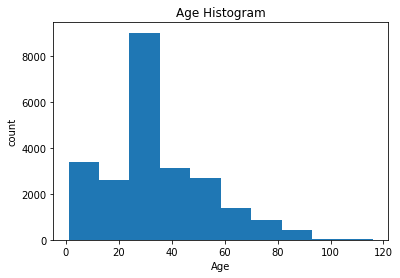

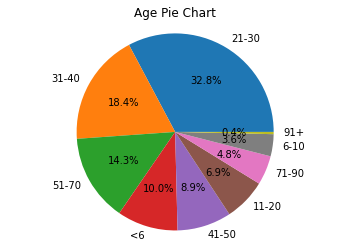

In [164]:
# plot histogram
hist_plot(dataframe)

# plot pie chart
bins = [0, 5, 10, 20, 30, 40, 50, 70, 90, np.inf]
labels = ['<6', '6-10', '11-20', '21-30', '31-40', '41-50', '51-70', '71-90', '91+']
age_binned = pd.cut(dataframe['age'], bins, labels=labels)
pie_plot(age_binned, "Age")

## Age Distribution
The following distribution shows the distribution of gender.

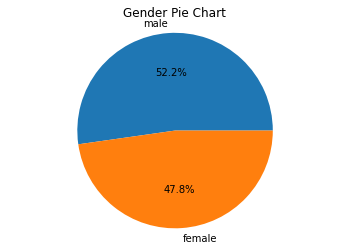

In [134]:
pie_plot(dataframe['gender'], "Gender")

## Race Distribution
The following distribution shows the distribution of all 5 races (white, black, asian, indian, and others).

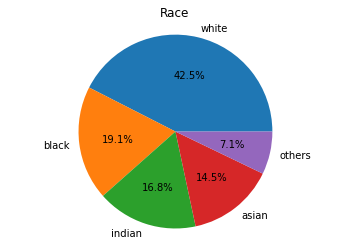

In [135]:
plot_pie(dataframe['race'], "Race")

## Dataset Separator
Splits the dataset into train, validation, and test splits.

In [181]:
class DatasetSeparator():
    def __init__(self, dataframe, train_size=5000, test_size=1000):
        self.dataframe = dataframe.sample(frac=1) # shuffles dataset
        self.maximum_age = dataframe['age'].max()
        self.train_size = train_size
        self.test_size = test_size
        self.progress_percent = 0.1

    def normalize_age(self, age):
        return (age / self.maximum_age)

    def normalize_image(self, image):
        return (np.array(image).flatten() / 255.0)

    def get_image(self, filename):
        return Image.open(filename)

    def get_race_value(self, race):
        return (dataset_label_ids['race_id'][race])

    def get_gender_value(self, gender):
        return (dataset_label_ids['gender_id'][gender])

    def preprocess_dataset(self, dataframe):
        # select subset of data
        dataframe = dataframe[:self.train_size + self.test_size]
        images = []
        # for printing progress
        progress_step = len(dataframe.index) * self.progress_percent
        # go through rows in dataframe
        for index, (row_index, image) in enumerate(dataframe.iterrows()):
            # normalize / update characteristics
            image['age'] = self.normalize_age(image['age'])
            image['race'] = self.get_race_value(image['race'])
            image['gender'] = self.get_gender_value(image['gender'])
            # normalize / update image data
            im = self.get_image(image['filename'])
            images.append(self.normalize_image(im))
            # show progress
            if (index % progress_step) == 0:
                print(f'~ Done {(index / len(dataframe.index)) * 100}%')
        # add images to dataframe
        images = np.array(images)
        # return modified dataset
        return images, dataframe

    def separate_dataset(self, images, dataframe):
        return train_test_split(
            images,
            dataframe[['age', 'race', 'gender', 'filename']],
            train_size=self.train_size,
            test_size=self.test_size
        )

    def get_dataset(self):
        images, dataframe = self.preprocess_dataset(self.dataframe)
        return self.separate_dataset(images, dataframe)

# separate dataset
dataset_separator = DatasetSeparator(dataframe)
train_x, test_x, train_y, test_y = dataset_separator.get_dataset()

~ Done 0.0%
~ Done 10.0%
~ Done 20.0%
~ Done 30.0%
~ Done 40.0%
~ Done 50.0%
~ Done 60.0%
~ Done 70.0%
~ Done 80.0%
~ Done 90.0%


In [182]:
print(train_y)

       age    race  gender                                           filename
13337   35   white  female  dataset/UTKFace/35_1_0_20170117134846646.jpg.c...
786     15  others  female  dataset/UTKFace/15_1_4_20170103223416559.jpg.c...
18993   54  indian    male  dataset/UTKFace/54_0_3_20170119210111784.jpg.c...
111     10   white  female  dataset/UTKFace/10_1_0_20170103175323250.jpg.c...
12365   34   white    male  dataset/UTKFace/34_0_0_20170117134853215.jpg.c...
...    ...     ...     ...                                                ...
13967   36   white  female  dataset/UTKFace/36_1_0_20170119192652946.jpg.c...
6467    26  indian    male  dataset/UTKFace/26_0_3_20170119181258652.jpg.c...
13625   36   white    male  dataset/UTKFace/36_0_0_20170104204247899.jpg.c...
17979   50  indian    male  dataset/UTKFace/50_0_3_20170109134300362.jpg.c...
554     14   white  female  dataset/UTKFace/14_1_0_20170109203340834.jpg.c...

[5000 rows x 4 columns]
